Interactively figure out MGRS tiles and track numbers

In [63]:
import asf_search as asf
import geopandas as gpd
from shapely.geometry import box
from shapely.ops import unary_union
from shapely import force_2d
from rasterio.crs import CRS
import pandas as pd
import yaml
from pathlib import Path
from tqdm import tqdm
import rasterio
import numpy as np
from asf_search import ASFSession
import http.cookiejar
from dem_stitcher.geojson_io import read_geojson_gzip
import backoff
from skimage.restoration import denoise_tv_bregman
import matplotlib.pyplot as plt

# Load Event Data

In [81]:
yaml_file = 'events/bangladesh_coastal_flood_2024.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'bangladesh_coastal_flood_2024',
 'bounds': [88.96546265, 21.65505773, 91.33990759, 24.17825791],
 'event_date': '2024-07-08',
 'pre_event_window_days': 100,
 'post_event_window_days': 60,
 'rtc_track_numbers': [137, 115],
 'mgrs_tiles': ['45QYE', '45QYF', '45QZE', '45QZF'],
 'dist_hls_confirmed_change_min_days': 30,
 'source_id': 'UNOSAT via https://data.humdata.org',
 'links': ['https://data.humdata.org/dataset/satellite-detected-water-extents-between-4-11-july-2024-in-bangladesh',
  'https://reliefweb.int/disaster/fl-2024-000088-bgd']}

# Read Geojson

In [65]:
p_json = Path(f'external_validation_data_db/{event_dict["event_name"]}.geojson')
p_parq = Path(f'external_validation_data_db/{event_dict["event_name"]}.parquet')
if p_json.exists():
    df_event = gpd.read_file(p_json)
else:
    df_event = gpd.read_parquet(p_parq)

<Axes: >

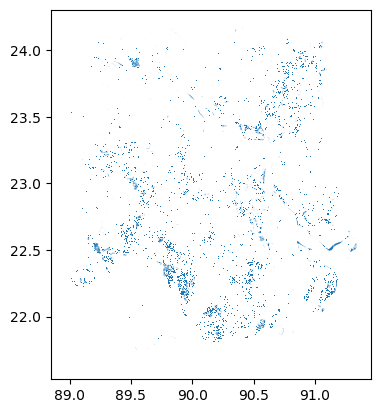

In [66]:
df_event.plot()

In [67]:
df_event.head()

name       date  \
0  bangladesh_coastal_flood_2024 2024-07-08   
1  bangladesh_coastal_flood_2024 2024-07-08   
2  bangladesh_coastal_flood_2024 2024-07-08   
3  bangladesh_coastal_flood_2024 2024-07-08   
4  bangladesh_coastal_flood_2024 2024-07-08   

                             source_id  \
0  UNOSAT via https://data.humdata.org   
1  UNOSAT via https://data.humdata.org   
2  UNOSAT via https://data.humdata.org   
3  UNOSAT via https://data.humdata.org   
4  UNOSAT via https://data.humdata.org   

                                            geometry  
0  MULTIPOLYGON (((89.51577 22.92842, 89.51568 22...  
1  MULTIPOLYGON (((90.18070 22.90734, 90.18061 22...  
2  MULTIPOLYGON (((89.68752 23.21052, 89.68752 23...  
3  MULTIPOLYGON (((90.07247 21.86330, 90.07202 21...  
4  MULTIPOLYGON (((89.24744 22.35108, 89.24717 22...

In [68]:
df_event.total_bounds

array([88.96546265, 21.65505773, 91.33990759, 24.17825791])

# Create Spatial AOI

In [69]:
aoi = box(*df_event.total_bounds)
df_aoi = gpd.GeoDataFrame(geometry=[aoi], crs=CRS.from_epsg(4326))

In [70]:
bounds = aoi.bounds
bounds

(88.96546264688368, 21.655057733227864, 91.3399075868657, 24.178257910474258)

# Find MGRS tiles and Explore

In [77]:
df_mgrs = gpd.read_parquet('mgrs.parquet')
df_mgrs_overlapping = df_mgrs[df_mgrs.geometry.intersects(aoi)].reset_index(drop=True)
# remove antimeridian
df_mgrs_overlapping = df_mgrs_overlapping[~df_mgrs_overlapping.intersects(box(-180, -60, -179, 60))]
df_mgrs_overlapping.head()

tile_id    epsg                                            utm_wkt  \
4   45QXD   32645  MULTIPOLYGON(((600000 2400000,600000 2290200,7...   
5   45QXE   32645  MULTIPOLYGON(((600000 2500020,600000 2390220,7...   
6   45QXF   32645  MULTIPOLYGON(((600000 2600040,600000 2490240,7...   
7   45QXG   32645  MULTIPOLYGON(((600000 2700000,600000 2590200,7...   
8   45QYD   32645  MULTIPOLYGON(((699960 2400000,699960 2290200,8...   

                                            geometry  
4  MULTIPOLYGON (((87.96675 21.70060, 87.96031 20...  
5  MULTIPOLYGON (((87.97294 22.60409, 87.96616 21...  
6  MULTIPOLYGON (((87.97945 23.50748, 87.97232 22...  
7  MULTIPOLYGON (((87.98630 24.41022, 87.97880 23...  
8  MULTIPOLYGON (((88.93279 21.69215, 88.91994 20...

In [78]:
m = df_mgrs_overlapping.explore(column='tile_id', categorical=True)
df_aoi.exterior.explore(m=m, style_kwds={'color':'black'})

# Select MGRS Tile(s)

In [82]:
MGRS_TILES = event_dict['mgrs_tiles']
MGRS_TILES

['45QYE', '45QYF', '45QZE', '45QZF']

In [83]:
df_mgrs_search = df_mgrs_overlapping[df_mgrs_overlapping.tile_id.isin(MGRS_TILES)].reset_index(drop=True)
search_geo = df_mgrs_search.geometry.unary_union

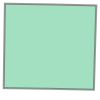

In [84]:
search_geo

# Explore Availability of RTC Data

In [85]:
import datetime
EVENT_DT = datetime.datetime.strptime(event_dict['event_date'], "%Y-%m-%d")
PRE_DT_START = EVENT_DT - datetime.timedelta(days=event_dict['pre_event_window_days'])
POST_DT_STOP = EVENT_DT + datetime.timedelta(days=event_dict['post_event_window_days'])


In [86]:
resp_pre = asf.geo_search(intersectsWith=search_geo.wkt,
                          processingLevel='RTC',
                          platform=asf.constants.SENTINEL1, 
                          start=PRE_DT_START, 
                          end=EVENT_DT)
len(resp_pre)

["'type': 'GEOMETRY_SIMPLIFICATION': 'report': 'Shape Simplified: shape of 16 simplified to 4 with proximity threshold of 0.004'", "'type': 'REVERSE': 'report': Reversed polygon winding order"]


730

In [87]:
resp_post = asf.geo_search(intersectsWith=search_geo.wkt,
                           processingLevel='RTC',
                           platform=asf.constants.SENTINEL1, 
                           start=EVENT_DT, 
                           end=POST_DT_STOP)
len(resp_post)

["'type': 'GEOMETRY_SIMPLIFICATION': 'report': 'Shape Simplified: shape of 16 simplified to 4 with proximity threshold of 0.004'", "'type': 'REVERSE': 'report': Reversed polygon winding order"]


255

In [92]:
df_rtc_resp_pre_e = gpd.GeoDataFrame.from_features(resp_pre.geojson(), crs=CRS.from_epsg(4326))
#df_rtc_resp_pre_e = df_rtc_resp_pre_e[df_rtc_resp_pre_e.pathNumber == 130].reset_index(drop=True)
df_rtc_resp_pre_e['geometry'] = df_rtc_resp_pre_e['geometry'].boundary
m = df_rtc_resp_pre_e.explore(alpha=.1, column='pathNumber', categorical=True, cmap='tab20c')
# if MGRS_TILES is not None:
#     df_mgrs_search.explore(m=m)
#df_aoi.explore(m=m)
m

In [93]:
df_rtc_resp_pre_e.pathNumber.unique()

array([114,  12, 150,  77,  48])

In [100]:
df_rtc_resp_post_e = gpd.GeoDataFrame.from_features(resp_post.geojson(), crs=CRS.from_epsg(4326))
#df_rtc_resp_post_e = df_rtc_resp_post_e[df_rtc_resp_post_e.pathNumber.isin([ 114])].boundary.reset_index(drop=True)
m = df_rtc_resp_post_e.explore()
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)

m

In [101]:
df_rtc_resp_post_e.head()

geometry  centerLat  centerLon  \
0  POLYGON ((88.82902 23.47525, 89.63405 23.60915...  23.635761  89.213001   
1  POLYGON ((88.86223 23.30900, 89.66620 23.44304...  23.459107  89.247748   
2  POLYGON ((88.89546 23.14262, 89.69838 23.27680...  23.292862  89.280441   
3  POLYGON ((88.06127 22.93881, 88.97088 23.09581...  23.100522  88.499064   
4  POLYGON ((88.92870 22.97611, 89.73058 23.11044...  23.126488  89.313151   

               stopTime                                             fileID  \
0  2024-08-14T12:13:14Z  OPERA_L2_RTC-S1_T012-023762-IW3_20240814T12131...   
1  2024-08-14T12:13:11Z  OPERA_L2_RTC-S1_T012-023761-IW3_20240814T12130...   
2  2024-08-14T12:13:08Z  OPERA_L2_RTC-S1_T012-023760-IW3_20240814T12130...   
3  2024-08-14T12:13:07Z  OPERA_L2_RTC-S1_T012-023760-IW2_20240814T12130...   
4  2024-08-14T12:13:06Z  OPERA_L2_RTC-S1_T012-023759-IW3_20240814T12130...   

  flightDirection  pathNumber processingLevel  \
0       ASCENDING          12             RTC   
1       ASCENDING          12             RTC   
2       ASCENDING          12             RTC   
3       ASCENDING          12             RTC   
4       ASCENDING          12             RTC   

                                                 url             startTime  \
0  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...  2024-08-14T12:13:11Z   
1  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...  2024-08-14T12:13:08Z   
2  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...  2024-08-14T12:13:05Z   
3  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...  2024-08-14T12:13:04Z   
4  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...  2024-08-14T12:13:02Z   

   ... validityStartDate subswath  \
0  ...              None      IW3   
1  ...              None      IW3   
2  ...              None      IW3   
3  ...              None      IW2   
4  ...              None      IW3   

                                            fileName beamModeType  \
0  OPERA_L2_RTC-S1_T012-023762-IW3_20240814T12131...           IW   
1  OPERA_L2_RTC-S1_T012-023761-IW3_20240814T12130...           IW   
2  OPERA_L2_RTC-S1_T012-023760-IW3_20240814T12130...           IW   
3  OPERA_L2_RTC-S1_T012-023760-IW2_20240814T12130...           IW   
4  OPERA_L2_RTC-S1_T012-023759-IW3_20240814T12130...           IW   

                                              s3Urls beamMode  \
0  [s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...       IW   
1  [s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...       IW   
2  [s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...       IW   
3  [s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...       IW   
4  [s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...       IW   

                                      additionalUrls bistaticDelayCorrection  \
0  [https://datapool.asf.alaska.edu/RTC/OPERA-S1/...                    TRUE   
1  [https://datapool.asf.alaska.edu/RTC/OPERA-S1/...                    TRUE   
2  [https://datapool.asf.alaska.edu/RTC/OPERA-S1/...                    TRUE   
3  [https://datapool.asf.alaska.edu/RTC/OPERA-S1/...                    TRUE   
4  [https://datapool.asf.alaska.edu/RTC/OPERA-S1/...                    TRUE   

  noiseCorrection postProcessingFilter  
0            TRUE                FALSE  
1            TRUE                FALSE  
2            TRUE                FALSE  
3            TRUE                FALSE  
4            TRUE                FALSE  

[5 rows x 33 columns]